# NLP: News Topic Modelling
## By Junbo Wang

1. Clean text (stopwords, whitespace characters, WordNetLemmatizer)
2. Build Bigram & Trigram models
3. LDA model & visualisation
4. Choose optiomal No. of topics
5. Analyse each topic

### Import packages

In [1]:
import nltk
import re
import pandas as pd
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# lemmatization
from nltk.stem import WordNetLemmatizer
# import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)

## Prepare stopwords

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Use 20 newsgroups text dataset
Contains 11,000 pieces of news from 20 topics

In [3]:
# Import data
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [4]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [6]:
len(df.target_names.unique())

20

## Clean texts

In [7]:
data = df.content.tolist()
data[2][:200]

'From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gav'

In [8]:
# Delete emails
data = [re.sub('\S+@\S+','',text) for text in data]

In [9]:
# Delete whitespace characters
data = [re.sub(r'\s+',' ',text) for text in data]

In [10]:
# Delete other characters
data = [re.sub(r"\'",' ',text) for text in data]

In [11]:
data[2][:200]

'From: (Thomas E Willis) Subject: PB questions... Organization: Purdue University Engineering Computer Network Distribution: usa Lines: 36 well folks, my mac plus finally gave up the ghost this weekend'

In [12]:
# Clean different forms
WNlemmatizer = WordNetLemmatizer()
data_stem = [WNlemmatizer.lemmatize(doc) for doc in data]

In [13]:
# Tokenize text
# Delete meaningless words & convert to lowercases & de-accents
# deacc = True removes punctuations
data_token = [gensim.utils.simple_preprocess(one_news, deacc=True) for one_news in data_stem]

In [14]:
print(data_token[2][:10])

['from', 'thomas', 'willis', 'subject', 'pb', 'questions', 'organization', 'purdue', 'university', 'engineering']


In [15]:
data_no_stopwords = [[word for word in doc if word not in stop_words] for doc in data_token]

## Build bigram and trigram models

In [16]:
# min_count – Ignore all words and bigrams with total collected count lower than this value.
# threshold – Represent a score threshold for forming the phrases (higher means fewer phrases).
bigram = gensim.models.Phrases(data_no_stopwords, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_no_stopwords],threshold = 100)

In [17]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
print(trigram_mod[bigram_mod[data_no_stopwords[0]]][:15])

['thing', 'car', 'nntp_posting_host', 'rac_wam_umd', 'organization', 'university_maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day']


In [19]:
data_bigram = [bigram_mod[doc] for doc in data_no_stopwords]
data_trigram = [trigram_mod[bigram_mod[doc]] for doc in data_no_stopwords]

## Dictionary and Corpus

In [20]:
id2word = corpora.Dictionary(data_bigram)
corpus = [id2word.doc2bow(text) for text in data_bigram] #Term Document Frequency

In [21]:
print(corpus[0])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]


In [22]:
# Human readable format of corpus (DF)
print([[(id2word[ids],freq) for ids, freq in cp] for cp in corpus[:1]][0][:15])

[('addition', 1), ('anyone', 2), ('body', 1), ('bricklin', 1), ('brought', 1), ('called', 1), ('car', 5), ('could', 1), ('day', 1), ('door', 1), ('doors', 1), ('early', 1), ('engine', 1), ('enlighten', 1), ('front_bumper', 1)]


## LDA Model

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 20,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)

In [24]:
pprint(lda_model.print_topics())

[(0,
  '0.028*"research" + 0.026*"information" + 0.021*"senses" + 0.014*"talking" + '
  '0.014*"center" + 0.013*"national" + 0.012*"via" + 0.011*"distribution" + '
  '0.011*"patient" + 0.011*"md"'),
 (1,
  '0.019*"first" + 0.018*"year" + 0.013*"two" + 0.013*"last" + 0.011*"team" + '
  '0.010*"next" + 0.009*"game" + 0.009*"time" + 0.008*"day" + 0.008*"second"'),
 (2,
  '0.047*"algorithm" + 0.042*"weapons" + 0.022*"amendment" + 0.020*"militia" + '
  '0.017*"reduced" + 0.016*"packet" + 0.016*"keep_bear" + 0.012*"black_white" '
  '+ 0.010*"restrictions" + 0.009*"tavares"'),
 (3,
  '0.046*"texas" + 0.025*"cds" + 0.025*"san_francisco" + 0.025*"nt" + '
  '0.019*"sys" + 0.013*"kit" + 0.011*"navy" + 0.009*"helsinki" + '
  '0.007*"singapore" + 0.007*"press_release"'),
 (4,
  '0.016*"timing" + 0.008*"der" + 0.004*"integra" + 0.002*"shaft" + '
  '0.002*"ns_simms" + 0.000*"snow" + 0.000*"atheist" + 0.000*"timer" + '
  '0.000*"crystal" + 0.000*"moonroof"'),
 (5,
  '0.033*"home" + 0.030*"internet" + 

In [25]:
doc_lda = lda_model[corpus]

## Measure model

In [26]:
# Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_bigram, dictionary = id2word, coherence = 'c_v')
print('Coherence Score: ', coherence_model_lda.get_coherence())

Coherence Score:  0.4646842221133343


# Topic visualisation

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Junbo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.385337  0.124698       1        1  25.790613
19    -0.347774  0.180898       2        1  17.700062
16    -0.282001 -0.206484       3        1  13.463226
1     -0.290560  0.098105       4        1  12.468544
8     -0.268927 -0.042611       5        1  11.663859
9      0.012410 -0.056713       6        1   4.839156
0     -0.101932 -0.304848       7        1   4.297887
5      0.011601 -0.026940       8        1   2.721151
13     0.056636  0.005355       9        1   1.785118
15     0.070396 -0.042969      10        1   1.001300
10     0.109861  0.006652      11        1   0.794986
6      0.136870  0.021886      12        1   0.749782
7      0.140169  0.030547      13        1   0.566472
12     0.148999  0.031805      14        1   0.547159
14     0.152519  0.031231      15        1   0.428645
17     0.157416  0.031759      16        1   0.389616
18     0.155872  0.031000      17        1   0.352459
2      0.166011  0.030034      18        1   0.250264
3      0.174555  0.029255      19        1   0.163097
4      0.183216  0.027341      20        1   0.026616, topic_info=      Category          Freq               Term         Total  loglift  \
6904   Default  54859.000000                 ax  54859.000000  30.0000   
33     Default  18286.000000       organization  18286.000000  29.0000   
23     Default  18970.000000              lines  18970.000000  28.0000   
262    Default  12213.000000             writes  12213.000000  27.0000   
227    Default  11612.000000            article  11612.000000  26.0000   
...        ...           ...                ...           ...      ...   
9133   Topic20      0.005047           somewhat      1.288500   2.6889   
11701  Topic20      0.005047          resources      1.288485   2.6889   
7899   Topic20      0.005047          existence      1.288540   2.6889   
69413  Topic20      0.005047  mr_stephanopoulos      1.288515   2.6889   
9226   Topic20      0.005047          arguments      1.288493   2.6889   

       logprob  
6904   30.0000  
33     29.0000  
23     28.0000  
262    27.0000  
227    26.0000  
...        ...  
9133  -11.3818  
11701 -11.3818  
7899  -11.3818  
69413 -11.3818  
9226  -11.3818  

[838 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1231      4  0.658714      ab
1231     13  0.337137      ab
4642      8  0.996335      ac
108       3  0.866993  access
108      10  0.132103  access
...     ...       ...     ...
52        2  0.113490   years
52        4  0.498528   years
52        5  0.387335   years
318       1  0.999194     yes
3240     13  0.995888    zone

[986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 20, 17, 2, 9, 10, 1, 6, 14, 16, 11, 7, 8, 13, 15, 18, 19, 3, 4, 5])

## LDA Mallet

In [28]:
from gensim.models.wrappers import LdaMallet
import os
os.environ.update({'MALLET_HOME':r'C:/Users/Junbo/mallet-2.0.8'})

In [29]:
mallet_path = 'C:\\Users\\Junbo\\mallet-2.0.8\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

[(11,
  [('drive', 0.014836598709745791),
   ('windows', 0.014465683742002146),
   ('card', 0.01193551378346514),
   ('system', 0.011471870073785584),
   ('scsi', 0.011445376147518182),
   ('dos', 0.011299659553047464),
   ('mac', 0.009577554345666256),
   ('bit', 0.009458331677462942),
   ('problem', 0.009431837751195538),
   ('mb', 0.009180145451655209)]),
 (1,
  [('file', 0.018882823972735586),
   ('information', 0.014671247679476878),
   ('list', 0.011249341941204178),
   ('send', 0.010806018120861157),
   ('mail', 0.010709041035161121),
   ('internet', 0.008755645451774681),
   ('number', 0.008672522235460363),
   ('info', 0.007965974896788674),
   ('program', 0.007868997811088636),
   ('read', 0.007411820121359896)]),
 (15,
  [('window', 0.009391110808294157),
   ('version', 0.008062501419454476),
   ('software', 0.007699121073788922),
   ('graphics', 0.007699121073788922),
   ('image', 0.00755149780836229),
   ('program', 0.007494719629352047),
   ('server', 0.006983716018259862

In [30]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_bigram, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6849655637202872


A significant improvement!

## Optimal No. of topics

In [31]:
def compute_coherence_values(dictionary, corpus, texts, max_num, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    max_num: Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, max_num, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigram, start=2, max_num=40, step=6)

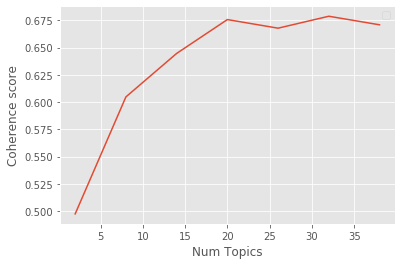

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

In [44]:
# Choose the best model
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"people" + 0.013*"time" + 0.010*"back" + 0.008*"told" + '
  '0.007*"started" + 0.006*"left" + 0.006*"home" + 0.006*"days" + '
  '0.006*"happened" + 0.006*"day"'),
 (1,
  '0.013*"people" + 0.010*"writes" + 0.010*"question" + 0.008*"reason" + '
  '0.007*"point" + 0.007*"true" + 0.007*"evidence" + 0.007*"make" + '
  '0.007*"wrong" + 0.006*"article"'),
 (2,
  '0.013*"team" + 0.012*"game" + 0.009*"hockey" + 0.008*"play" + 0.007*"games" '
  '+ 0.006*"nhl" + 0.006*"season" + 0.006*"win" + 0.006*"year" + '
  '0.005*"players"'),
 (3,
  '0.008*"article" + 0.008*"organization" + 0.008*"lines" + 0.005*"writes" + '
  '0.005*"medical" + 0.005*"problems" + 0.005*"time" + 0.005*"gordon_banks" + '
  '0.004*"science" + 0.004*"food"'),
 (4,
  '0.016*"information" + 0.010*"list" + 0.008*"group" + 0.007*"university" + '
  '0.007*"send" + 0.006*"general" + 0.006*"mail" + 0.005*"research" + '
  '0.005*"service" + 0.005*"address"'),
 (5,
  '0.015*"drive" + 0.014*"windows" + 0.012*"system" + 0.01

## Keywords and topics for each news

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_bigram):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_bigram)# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.1380,"car, article, writes, organization, bike, line...","[thing, car, nntp_posting, host, rac_wam, umd,..."
1,1,5.0,0.1915,"drive, windows, system, card, scsi, dos, bit, ...","[guy_kuo, si, clock, poll, final, call, summar..."
2,2,5.0,0.1831,"drive, windows, system, card, scsi, dos, bit, ...","[thomas, willis, pb, questions, organization, ..."
3,3,5.0,0.1563,"drive, windows, system, card, scsi, dos, bit, ...","[joe, green, weitek, organization, harris, com..."
4,4,10.0,0.1229,"space, nasa, earth, data, research, moon, laun...","[jonathan, mcdowell, shuttle_launch, question,..."
5,5,18.0,0.4923,"gun, people, state, law, guns, article, police...","[foxvog_douglas, rewording_second, amendment, ..."
6,6,3.0,0.1534,"article, organization, lines, writes, medical,...","[brian, manning, delaney, brain, tumor, treatm..."
7,7,5.0,0.6015,"drive, windows, system, card, scsi, dos, bit, ...","[grubb_ide, vs, scsi, organization, new_mexico..."
8,8,14.0,0.1250,"file, window, program, version, files, server,...","[win, icon, help, please, organization, univer..."
9,9,5.0,0.2135,"drive, windows, system, card, scsi, dos, bit, ...","[stan_kerr, sigma_designs, double, article, ux..."


## Most iconic news in each topic

In [47]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9061,"people, time, back, told, started, left, home,...","[david_davidian, accounts_anti, armenian, huma..."
1,1.0,0.6792,"people, writes, question, reason, point, true,...","[mathew, alt_atheism, faq, constructing_logica..."
2,2.0,0.9392,"team, game, hockey, play, games, nhl, season, ...","[rocket, nhl, final, point, standings, organiz..."
3,3.0,0.7540,"article, organization, lines, writes, medical,...","[prevent, kidney_stone, formation, lines, nntp..."
4,4.0,0.6882,"information, list, group, university, send, ge...","[steve, wu, crypto, final, call, organization,..."


# No. of documents for each topic

In [48]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,19.0,"car, article, writes, organization, bike, line...",188.0,0.0166
1.0,5.0,"drive, windows, system, card, scsi, dos, bit, ...",437.0,0.0386
2.0,5.0,"drive, windows, system, card, scsi, dos, bit, ...",611.0,0.0540
3.0,5.0,"drive, windows, system, card, scsi, dos, bit, ...",541.0,0.0478
4.0,10.0,"space, nasa, earth, data, research, moon, laun...",215.0,0.0190
...,...,...,...,...
11309.0,3.0,"article, organization, lines, writes, medical,...",NaN,NaN
11310.0,5.0,"drive, windows, system, card, scsi, dos, bit, ...",NaN,NaN
11311.0,5.0,"drive, windows, system, card, scsi, dos, bit, ...",NaN,NaN
11312.0,8.0,"line, current, file, entry, output, number, li...",NaN,NaN
